# Adult Dataset Anonymization and Classification

Anonymization techniques such as k-anonymization, as well as it's modifications l-diversity and t-closeness provide individuals' anonymity in datasets, but can significantly disturb performance of machine learning algorithms. 

In this notebook Adult dataset from UCI Machine Learning Repository is used to depict this behavior. We will perform a classification; try to predict 'income' attribute based on other features from the dataset. 

k-anonymization technique provides anonymity for the individuals in dataset such that they cannot be distinguished from at least k-1 other individuals from the dataset. Experiments are done with different k values in order to both:
<ul>
<li>see characteristics of anonymized datasets</li>
<li>analyze the results of the same classification task using anonymized data.</li>
</ul>

## Adult Dataset Classification

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn import metrics, preprocessing, model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from pprint import pprint
from IPython.display import Image

import warnings

warnings.filterwarnings('ignore')

### Data analysis and preprocessing

Let's load the data from UCI, define attributes' names and have a look into the data.

In [127]:
# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
             'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
dataset = pd.read_csv(url, names=names, sep=r'\s*,\s*', na_values="?", engine='python')
dataset.shape

(32561, 15)

In [128]:
# the first look into the data
dataset.head(15)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


We have some missing values in the dataset so we will remove the rows containing missing values.

That leaves us with 30162 entries out of 32561.

In [129]:
# cleaning the data
dataset = dataset.dropna()
dataset.shape

(30162, 15)

We plot distribution of each feature some some more insights.

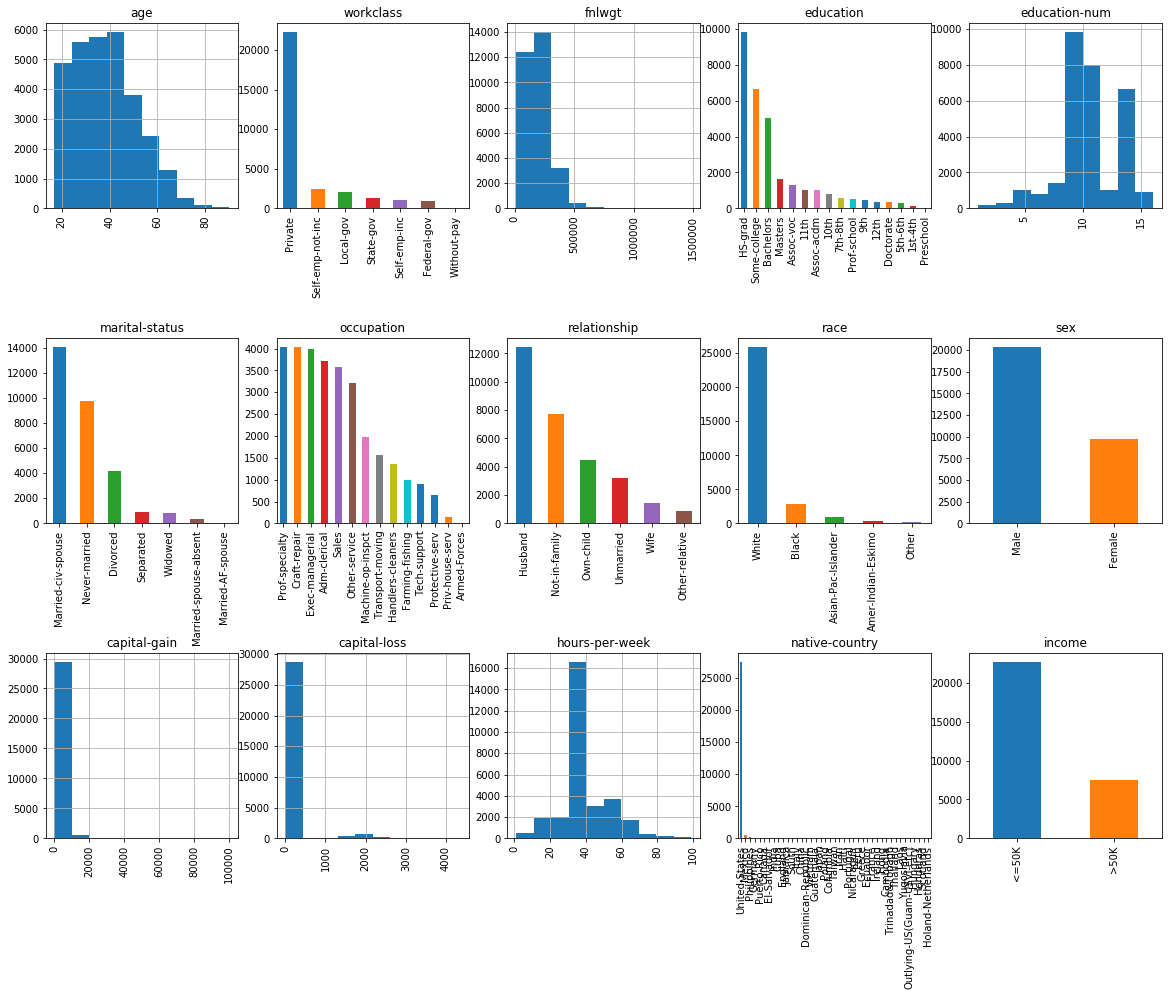

In [130]:
# plot the distribution of each feature
fig = plt.figure(figsize=(20, 15))
cols = 5
rows = math.ceil(float(dataset.shape[1]) / cols)
for i, column in enumerate(dataset.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if dataset.dtypes[column] == np.object:
        dataset[column].value_counts().plot(kind="bar", axes=ax)
    else:
        dataset[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

From this we can see that dataset contains mostly white men from the USA while USA is also the native country of big majority of the people from the database.

In [131]:
dataset['native-country'].value_counts() / dataset.shape[0]

United-States                 0.911876
Mexico                        0.020224
Philippines                   0.006233
Germany                       0.004244
Puerto-Rico                   0.003614
Canada                        0.003548
El-Salvador                   0.003315
India                         0.003315
Cuba                          0.003050
England                       0.002851
Jamaica                       0.002652
South                         0.002354
Italy                         0.002254
China                         0.002254
Dominican-Republic            0.002221
Vietnam                       0.002122
Guatemala                     0.002089
Japan                         0.001956
Poland                        0.001857
Columbia                      0.001857
Taiwan                        0.001392
Iran                          0.001392
Haiti                         0.001392
Portugal                      0.001127
Nicaragua                     0.001094
Peru                     

Less than 9% of the people are from non-US countries all together. For that reason we define value "Non-US" and group all the other appropriate values into this one.

Since most of the classifiers work with numerical data, we will encode categorical data from the dataset to integers using scikit's LabelEncoder.

In [132]:
def number_encode_features(ds):
    result = ds.copy()
    encoders = {}
    for feature in result.columns:
        if result.dtypes[feature] == np.object:
            encoders[feature] = preprocessing.LabelEncoder()
            result[feature] = encoders[feature].fit_transform(result[feature].astype(str))
    return result, encoders

dataset_encoded, encoders = number_encode_features(dataset)

We create heatmap to explore the correlation between attributes.

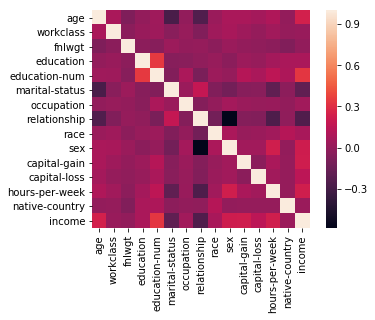

In [133]:
sns.heatmap(dataset_encoded.corr(), square=True)

In [134]:
# education and education-num are the same features -> keep education-num because it's ordered
del dataset['education']
dataset_encoded, encoders = number_encode_features(dataset)
dataset_encoded.shape

(30162, 14)

Finally, we can plot the distribution of preprocessed attributes.

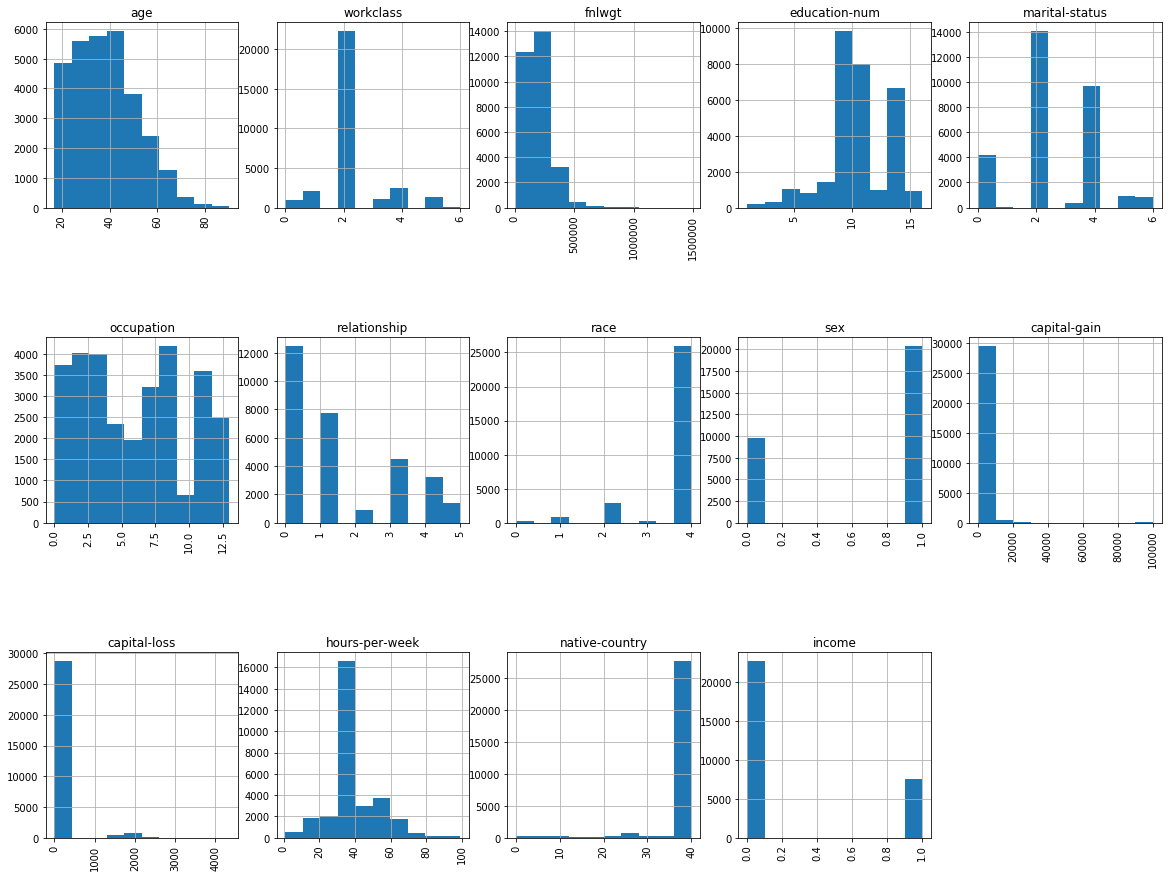

In [135]:
# distribution of encoded attributes
fig = plt.figure(figsize=(20, 15))
cols = 5
rows = math.ceil(float(dataset_encoded.shape[1]) / cols)
for i, column in enumerate(dataset_encoded.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    dataset_encoded[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

As we want to predict whether person's income is <=50k or >50k, we define out target attribute *income* and scale the data.

In [136]:
# define target attribute
X = dataset_encoded[dataset_encoded.columns[:-1]]
y = dataset_encoded['income']

scaler = preprocessing.StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.shape

(30162, 13)

### Prediction

Now when data is read we will predict the income attribute with decision tree classifier and measure accuracy and f1 score.

In [137]:
# define classifier
clf = DecisionTreeClassifier()

In [138]:
# cross validation
scores = model_selection.cross_validate(clf, X, y, scoring = ['accuracy', 'f1'], cv=10)
print("Accuracy: %0.2f (+/- %0.2f)\nF1 score: %0.2f (+/- %0.2f)" 
      % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2,
        scores['test_f1'].mean(), scores['test_f1'].std() * 2))

Accuracy: 0.81 (+/- 0.01)
F1 score: 0.61 (+/- 0.02)


In [139]:
# predicition
predicted = model_selection.cross_val_predict(clf, X, y, cv=10)

Text(0.5,442.811,'Predicted value')

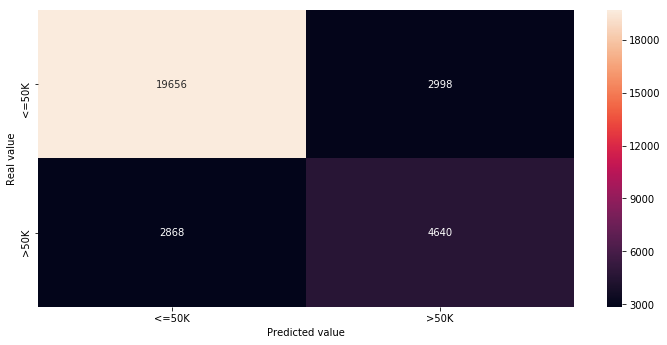

In [140]:
# confusion matrix
cm = metrics.confusion_matrix(y, predicted)

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoders["income"].classes_,
            yticklabels=encoders["income"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

In [141]:
# accuracy
metrics.accuracy_score(y, predicted)

0.8055168755387574

In [142]:
# f1 score 
metrics.f1_score(y, predicted)

0.6127030239006999

Both scores seem good. With the original data we have around 81% correct predictions!

## k-anonymity model

We want to make our dataset k-anonymous, i.e. we want to ensure that the individuals from the Adult dataset cannot be distinguished from at least k-1 other individuals from the dataset. ARX software is the tool used here for k-anonymization. The user can define her own hierarchies for quasi-identifiers, it contains the interface for comparing non- with anonymized data, as well as the solution space in lattice graph, statistical information, and much more.

We perform k-anonymization for the following k-s: 2, 3, 7, 10, 33, 100. Then we do the classification with data anonymized in that way and compare results to classification on the original data. For all attributes we use method called *generalization* to achieve k-anonymity. By generalizing we replace individual values of attributes with a broader category.

For example, for attribute *hours-per-week* the defined hierarchy of categories is [0-80] -> [<40, 40, >40] -> [* ] ("* " stands for "fully anonymized"). *education-number* is on the first level anonymized as [elementary-scool, high-school, college-up-to-bachelors, advanced-studies], and on the second level completely anonymized. Other attributes are generalized similarily.

The attributes all have the equal importance weights in the following results.

### 3-anonymization

Let's see first how our anonymized data look like. We choose k=3 and follow the same steps as in previous classification of the original data.

In [85]:
# reads the data from the csv file with specific filepath
def read_anon_data(k):
    directory = "C:/Users/tsarcevic/PycharmProjects/Anonymization/data/adult_k"
    ext = ".csv"
    filepath = directory + str(k) + ext
    dataset = pd.read_csv(filepath, sep=r'\s*,\s*', na_values="?", engine='python')
    return dataset

We define *k* and read data previously anonymized using ARX tool and stored on disc.

In [124]:
k = 3
dataset = read_anon_data(k)
dataset.head(15)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,*,*,*,1,Married,*,Other-relative,*,Female,0,0,40,Non-US,<=50K
1,*,*,*,1,Married,*,Wife,*,Female,0,0,40,Non-US,<=50K
2,*,*,*,1,Married,*,Wife,*,Female,4508,0,40,Non-US,<=50K
3,*,*,*,1,Married,*,Wife,*,Female,0,0,40,Non-US,<=50K
4,*,*,*,1,Married,*,Wife,*,Female,0,0,40,Non-US,<=50K
5,*,*,*,1,Married,*,Wife,*,Female,0,0,40,Non-US,<=50K
6,*,*,*,1,Married,*,Wife,*,Female,0,0,40,Non-US,<=50K
7,*,*,*,1,Married,*,Wife,*,Female,0,0,40,Non-US,<=50K
8,*,*,*,1,Married,*,Wife,*,Female,0,0,40,Non-US,<=50K
9,*,*,*,1,Married,*,Not-in-family,*,Female,0,0,40,Non-US,<=50K


To achieve 3-anonymity, 5 attributes have been completely anonymized: *age, workclass, fnlwgt, occupation* and *race*. 

Attribute *education-number* has been anonymized to level 1 creating 4 previously defined groups. *marital-status* is anonymized to level 1 (groups: married, not-married) as well as *hours-per-week*.

Intuitively, it is possible to anonymize data in more different ways. With ARX tool it is possible to define utility measure to be used for calculating the optimal anonymization solution. In this example we use loss utility measure. Part of the solution space can be seen on image below. It is represented as lattice diagram. Numbers within the nodes represent levels of anonymization for each attribute. Green nodes are anonymous solutions and the yellow one is our optimal one. 

We can see, for exaple that attribute *age* has been anonymized to level 2 in its hierarchy which yields complete anonymization for that attribute. Also, we can see the last attribute - *native-country* is anonymized at level 0, meaning it remained unchanged.

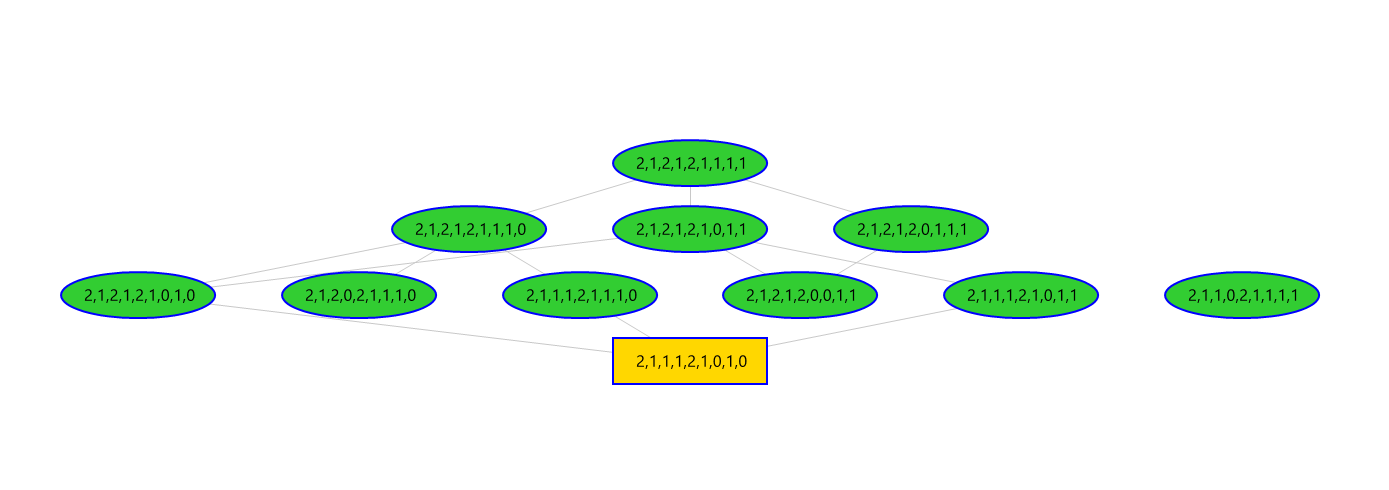

In [87]:
Image("C:/Users/tsarcevic/PycharmProjects/Anonymization/plots/anon_sol_space_k3.png")

ARX is providing statistical analysis on the anonymized data, plots of distribution of each attribute, contingency graphs, etc. Here are some interesting measures obtained from ARX. Notice that even though the 3-anonymity is performed, the minimal class size is 4.

In [19]:
stats = pd.read_csv("C:/Users/tsarcevic/Documents/Datasets/stats_k3.csv", sep=r'\s*;\s*', na_values="?", engine='python')
pprint(stats)

              "Measure   Including outliers   Excluding outliers"
0  "Average class size  314.1875 (1.04167%)  314.1875 (1.04167%)"
1  "Maximal class size       2638 (8.7461%)       2638 (8.7461%)"
2  "Minimal class size         4 (0.01326%)         4 (0.01326%)"
3   "Number of classes                   96                   96"
4   "Number of records                30162         30162 (100%)"
5  "Suppressed records               0 (0%)                    0"


### Classification

Since completely anonymized attributes are not useful in classification we can remove them.

In [125]:
# remove anonymized columns
del dataset['age'],dataset['workclass'],dataset['fnlwgt'],dataset['occupation'],dataset['race']
dataset.shape

(30162, 9)

It is also useful to see how values of the attributes are distributed now, after the anonymization. Those diagrams is also possible to see in ARX. 

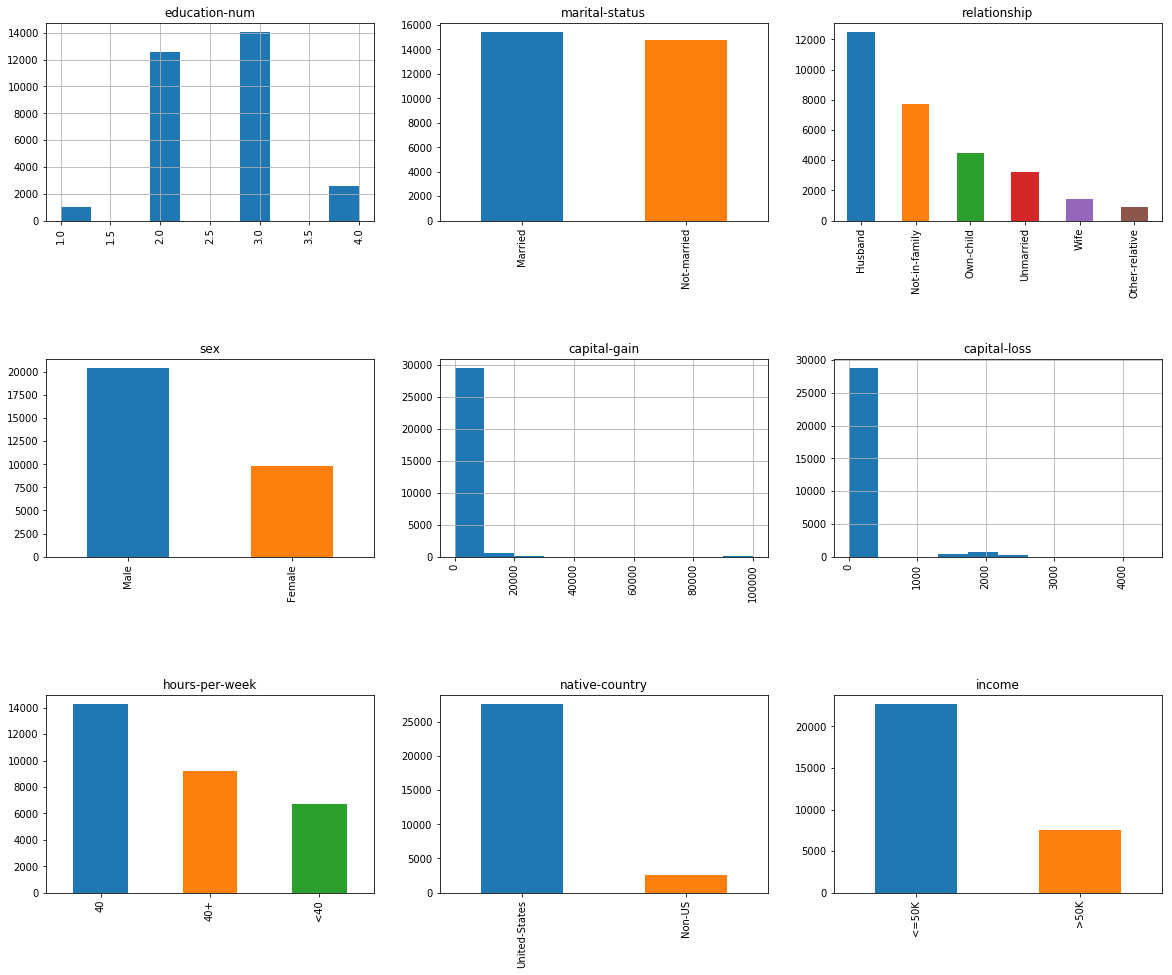

In [89]:
# plot the distribution of each feature
fig = plt.figure(figsize=(20, 16))
cols = 3
rows = math.ceil(float(dataset.shape[1]) / cols)
for i, column in enumerate(dataset.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if dataset.dtypes[column] == np.object:
        dataset[column].value_counts().plot(kind="bar", axes=ax)
    else:
        dataset[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [90]:
# again we encode the caterorical values
dataset_encoded, encoders = number_encode_features(dataset)

In [100]:
# define target & scale
X = dataset_encoded[dataset_encoded.columns[:-1]]
y = dataset_encoded['income']
scaler = preprocessing.StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

(30162, 8)

For the comparison we use Decision Tree Classifier and calculate related metrics using cross validation.

In [92]:
scores = model_selection.cross_validate(clf, X, y, cv=10, scoring=['accuracy','f1'])
print("Accuracy: %0.2f (+/- %0.2f)\nF1 score: %0.2f (+/- %0.2f)" 
      % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2,
        scores['test_f1'].mean(), scores['test_f1'].std() * 2))

Accuracy: 0.47 (+/- 0.42)
F1 score: 0.26 (+/- 0.28)


In [95]:
# predicition
predicted = model_selection.cross_val_predict(clf, X, y, cv=10)
# accuracy score
metrics.accuracy_score(y, predicted)

0.46764140308998076

Text(0.5,442.811,'Predicted value')

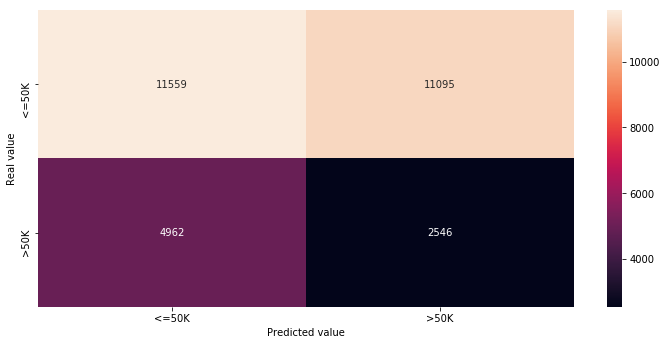

In [97]:
cm = metrics.confusion_matrix(y, predicted)

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoders["income"].classes_,
            yticklabels=encoders["income"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

In [98]:
metrics.f1_score(y, predicted)

0.24076788500638333

### Comparing k-anonymity models

Now we can anonymize Adult dataset with other *k* values and use them for the same classification task. We will experiment with 7 different values and use 3 different classifiers. We use accuracy score and f1 score for the comparison.  

In [150]:
k_values = [1,2,3,7,10,33,100]
acc_scores = {"Decision Tree" : [], "Logistic Regression" : [], "Linear SVC" : [], "Random Forest" : [], "Gradient Boosting" : [], "Neural Network" : []}
f1_scores = {"Decision Tree" : [], "Logistic Regression" : [], "Linear SVC" : [], "Random Forest" : [], "Gradient Boosting" : [], "Neural Network" : []}

tree = DecisionTreeClassifier(random_state=0)
lin = LogisticRegression(random_state=0)
svc = LinearSVC(random_state=0)
forest = RandomForestClassifier(max_depth=2, random_state=0)
grad = GradientBoostingClassifier(random_state=0)
mlp = MLPClassifier(random_state=0)

The data is previously anonymized using ARX.

In [151]:
for k in k_values:
    dataset = read_anon_data(k)
    
    # delete anonymized data
    for i, column in enumerate(dataset):
        if "*" == dataset[column][0]:
            del dataset[column]
            
    # preprocess
    dataset_encoded, encoders = number_encode_features(dataset)
    X = dataset_encoded[dataset_encoded.columns[:-1]]
    y = dataset_encoded['income']
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # predicition
    y_pred_tree = model_selection.cross_val_predict(tree, X, y, cv=10)
    y_pred_lin = model_selection.cross_val_predict(lin, X, y, cv=10)
    y_pred_svc = model_selection.cross_val_predict(svc, X, y, cv=10)
    y_pred_forest = model_selection.cross_val_predict(forest, X, y, cv=10)
    y_pred_grad = model_selection.cross_val_predict(grad, X, y, cv=10)
    y_pred_mlp = model_selection.cross_val_predict(mlp, X, y, cv=10)
    
    # accuracy scores
    acc_scores["Decision Tree"].append(metrics.accuracy_score(y_pred_tree, y))
    acc_scores["Logistic Regression"].append(metrics.accuracy_score(y_pred_lin, y))
    acc_scores["Linear SVC"].append(metrics.accuracy_score(y_pred_svc, y))
    acc_scores["Random Forest"].append(metrics.accuracy_score(y_pred_forest, y))
    acc_scores["Gradient Boosting"].append(metrics.accuracy_score(y_pred_grad, y))
    acc_scores["Neural Network"].append(metrics.accuracy_score(y_pred_mlp, y))

    
    # f1 scores
    f1_scores["Decision Tree"].append(metrics.f1_score(y_pred_tree, y))
    f1_scores["Logistic Regression"].append(metrics.f1_score(y_pred_lin, y))
    f1_scores["Linear SVC"].append(metrics.f1_score(y_pred_svc, y))
    f1_scores["Random Forest"].append(metrics.f1_score(y_pred_forest, y))
    f1_scores["Gradient Boosting"].append(metrics.f1_score(y_pred_grad, y))
    f1_scores["Neural Network"].append(metrics.f1_score(y_pred_mlp, y))

Let's see how f1 score depends on k value in different classifiers.

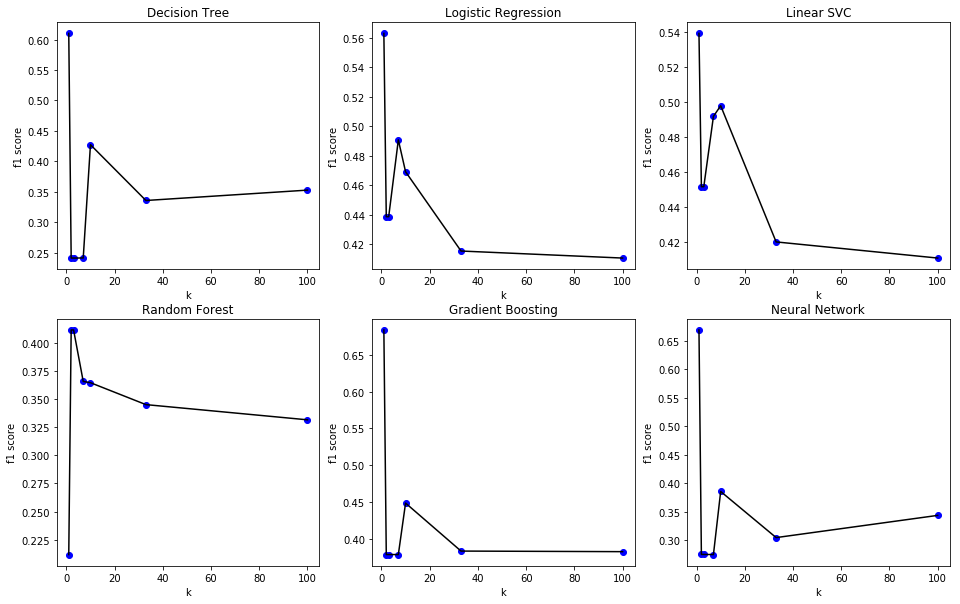

In [153]:
fig = plt.figure(figsize=(16, 10))

cols = 3
rows = math.ceil(float(len(f1_scores)) / cols)
for i, clf in enumerate(f1_scores.items()):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(clf[0])

    plt.plot(k_values, clf[1], 'bo', k_values, clf[1], 'k')
    plt.ylabel('f1 score')
    plt.xlabel('k')

Accuracy score:

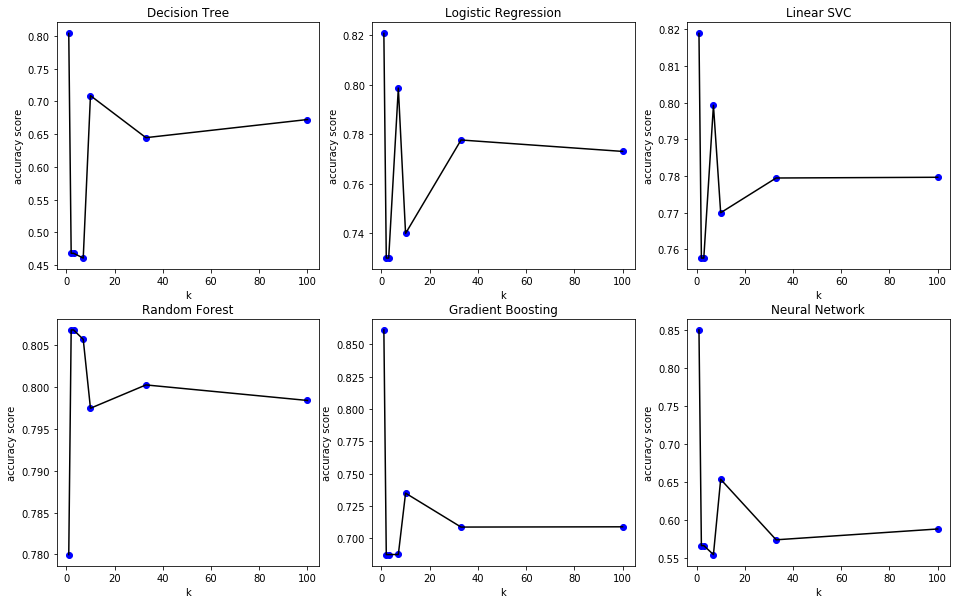

In [154]:
fig = plt.figure(figsize=(16, 10))

cols = 3
rows = math.ceil(float(len(acc_scores)) / cols)
for i, clf in enumerate(acc_scores.items()):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(clf[0])

    plt.plot(k_values, clf[1], 'bo', k_values, clf[1], 'k')
    plt.ylabel('accuracy score')
    plt.xlabel('k')

It's possible to notice a significant decrease of f1 score in Logistic Regression and Linear SVC when k=7. Let't try to explore why is that so by comparing anonymized data with k=7 and k=10.

The anonymity pattern for k=7 is (2,1,1,**2**,2,1,0,1,0). The anonymity pattern for k=10 is (2,1,1,**1**,2,1,0,2,0). The *marital-status* attribute is the one more anonymized in the first case. Since we didn't set any weights to the attributes, they are all considered equally important. 

In order to try to obtain better solution for k=7 we will choose some suboptimal anonymization model that doesn't completely anonymize *marital-status*.


In [31]:
# TODO not relevant now; everything below
dataset = pd.read_csv("C:/Users/tsarcevic/PycharmProjects/Anonymization/data/adult_k7_1.csv", sep=r'\s*,\s*', na_values="?", engine='python')

# delete anonymized data
for i, column in enumerate(dataset):
    if "*" == dataset[column][0]:
        del dataset[column]
        
dataset_encoded, encoders = number_encode_features(dataset)
X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset_encoded[dataset_encoded.columns[:-1]],
                                                                    dataset_encoded['income'], train_size=0.70)
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

# train
tree.fit(X_train, y_train)
lin.fit(X_train, y_train)
svc.fit(X_train, y_train)

# predicition
y_pred_tree = tree.predict(X_test)
y_pred_lin = lin.predict(X_test)
y_pred_svc = svc.predict(X_test)

# accuracy scores
acc_scores["Decision Tree"][3] = metrics.accuracy_score(y_pred_tree, y_test)
acc_scores["Logistic Regression"][3] = metrics.accuracy_score(y_pred_lin, y_test)
acc_scores["Linear SVC"][3] = metrics.accuracy_score(y_pred_svc, y_test)

# f1 scores
f1_scores["Decision Tree"][3] = metrics.f1_score(y_pred_tree, y_test)
f1_scores["Logistic Regression"][3] = metrics.f1_score(y_pred_lin, y_test)
f1_scores["Linear SVC"][3] = metrics.f1_score(y_pred_svc, y_test)

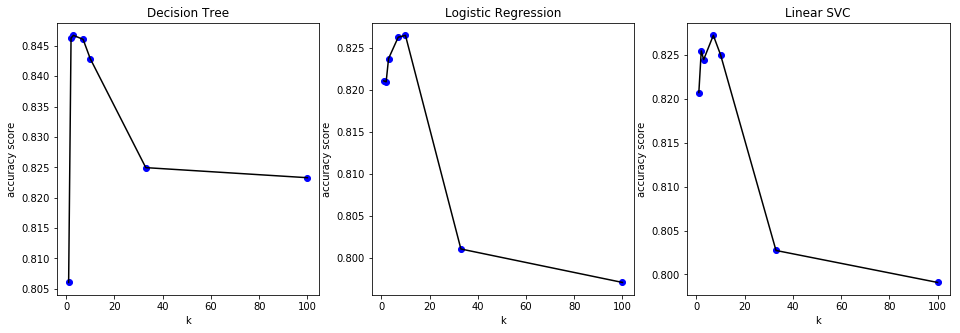

In [32]:
fig = plt.figure(figsize=(16, 5))

cols = 3
rows = math.ceil(float(len(acc_scores)) / cols)
for i, clf in enumerate(acc_scores.items()):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(clf[0])

    plt.plot(k_values, clf[1], 'bo', k_values, clf[1], 'k')
    plt.ylabel('accuracy score')
    plt.xlabel('k')

This looks better. Let's try just one more suboptimal solution with anonymization pattern (2,1,2,1,2,1,0,1,0):

In [33]:
dataset = pd.read_csv("C:/Users/tsarcevic/PycharmProjects/Anonymization/data/adult_k7_2.csv", sep=r'\s*,\s*', na_values="?", engine='python')

# delete anonymized data
for i, column in enumerate(dataset):
    if "*" == dataset[column][0]:
        del dataset[column]
        
dataset_encoded, encoders = number_encode_features(dataset)
X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset_encoded[dataset_encoded.columns[:-1]],
                                                                    dataset_encoded['income'], train_size=0.70)
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

# train
tree.fit(X_train, y_train)
lin.fit(X_train, y_train)
svc.fit(X_train, y_train)

# predicition
y_pred_tree = tree.predict(X_test)
y_pred_lin = lin.predict(X_test)
y_pred_svc = svc.predict(X_test)

# accuracy scores
acc_scores["Decision Tree"][3] = metrics.accuracy_score(y_pred_tree, y_test)
acc_scores["Logistic Regression"][3] = metrics.accuracy_score(y_pred_lin, y_test)
acc_scores["Linear SVC"][3] = metrics.accuracy_score(y_pred_svc, y_test)

# f1 scores
f1_scores["Decision Tree"][3] = metrics.f1_score(y_pred_tree, y_test)
f1_scores["Logistic Regression"][3] = metrics.f1_score(y_pred_lin, y_test)
f1_scores["Linear SVC"][3] = metrics.f1_score(y_pred_svc, y_test)

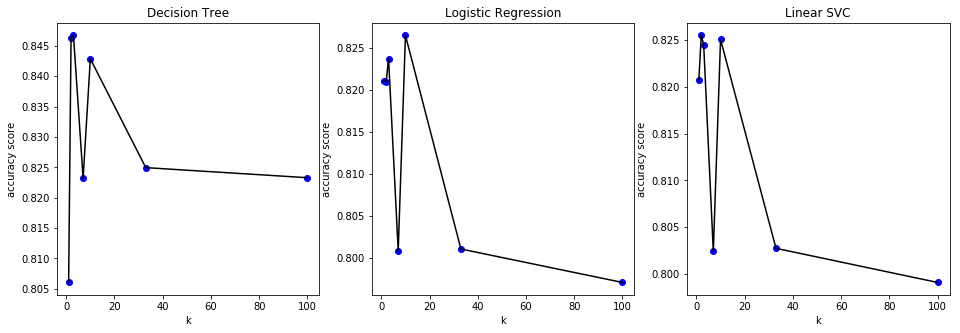

In [34]:
fig = plt.figure(figsize=(16, 5))

cols = 3
rows = math.ceil(float(len(acc_scores)) / cols)
for i, clf in enumerate(acc_scores.items()):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(clf[0])

    plt.plot(k_values, clf[1], 'bo', k_values, clf[1], 'k')
    plt.ylabel('accuracy score')
    plt.xlabel('k')

In the last one we didn't completely anonymize *marital-status*, but we completely anonymize *education-num* and the results obtained are even worse. Second solution remains as the best one.